# Preparação de ambiente

In [ ]:
!pip install -q pyspark==3.3.0 spark-nlp==3.2.3


In [ ]:
from sparknlp.pretrained import PretrainedPipeline
import sparknlp
from pyspark.sql import SparkSession
from pyspark.ml import Pipeline
from sparknlp.base import DocumentAssembler, Finisher
from sparknlp.annotator import (Lemmatizer, Stemmer, Tokenizer, Normalizer, StopWordsCleaner)
from pyspark.sql.functions import monotonically_increasing_id

spark = sparknlp.start()

In [ ]:
import nltk

nltk.download("stopwords")

sw = nltk.corpus.stopwords.words("portuguese")

#adição de palavras a serem removidas
new_stopwords = ['xml', 'dao', 'nt', 'das', 'tag', 'regras', 'resumo',
 'validação', 'alteração', 'validações', 'alterações', 'campos', 'chave'
'acesso', 'dias', 'contados', 'obrig', 'mensagem', 'indntermed', 'yaa', 'site'
]
sw.extend(new_stopwords)

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [ ]:
##from google.colab import drive
##drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
#dataset adicionado contendo as NTs coletadas do website do governo "https://www.nfe.fazenda.gov.br/portal/listaConteudo.aspx?tipoConteudo=04BIflQt1aY="
file_path = ".../notastecnicas.csv"

data = spark.read.option("header", True).csv(file_path)

In [ ]:
from pyspark.sql import functions as fun

In [ ]:
df = data.withColumn('content', fun.explode(fun.split(fun.col("Texto"),"</doc>")))
df = df.drop(fun.col('Texto'))
df.show(4, truncate=False, vertical=True)

-RECORD 0-------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------

In [ ]:
df = df.withColumn("id_doc", monotonically_increasing_id())
df.show(4, truncate=False, vertical=True)

-RECORD 0-------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------

In [ ]:
#adicinado regex para remoção de palavras curtas
from pyspark.sql.functions import regexp_replace

In [ ]:
df = df.withColumn("content",
      regexp_replace("content", r"\b\w{1,2}\b", ""))
df.show(4, vertical=True, truncate=False)

-RECORD 0-------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------

# Definição dos passos do pipeline

In [ ]:
document_assembler = DocumentAssembler()\
  .setInputCol("content")\
  .setOutputCol("document")\

tokenizer = Tokenizer()\
  .setInputCols(["document"])\
  .setOutputCol("token")

normalizer = Normalizer()\
  .setInputCols(["token"])\
  .setOutputCol("normalized")\
  .setLowercase(True)

stopwords_cleaner = StopWordsCleaner()\
  .setInputCols("normalized")\
  .setOutputCol("cleanTokens")\
  .setCaseSensitive(False)\
  .setStopWords(sw)

finisher = Finisher()\
  .setInputCols(["cleanTokens"])\
  .setOutputCols(["tokens"])\
  .setOutputAsArray(True)\
  .setCleanAnnotations(False)

In [ ]:
nlp_pipeline = Pipeline(stages=[document_assembler,
                            tokenizer,
                            normalizer,
                            stopwords_cleaner,
                            finisher])

In [ ]:
nlp_model = nlp_pipeline.fit(df)
processed_df = nlp_model.transform(df)
processed_df.printSchema()

root
 |-- Nome do arquivo: string (nullable = true)
 |-- content: string (nullable = false)
 |-- id_doc: long (nullable = false)
 |-- document: array (nullable = true)
 |    |-- element: struct (containsNull = true)
 |    |    |-- annotatorType: string (nullable = true)
 |    |    |-- begin: integer (nullable = false)
 |    |    |-- end: integer (nullable = false)
 |    |    |-- result: string (nullable = true)
 |    |    |-- metadata: map (nullable = true)
 |    |    |    |-- key: string
 |    |    |    |-- value: string (valueContainsNull = true)
 |    |    |-- embeddings: array (nullable = true)
 |    |    |    |-- element: float (containsNull = false)
 |-- token: array (nullable = true)
 |    |-- element: struct (containsNull = true)
 |    |    |-- annotatorType: string (nullable = true)
 |    |    |-- begin: integer (nullable = false)
 |    |    |-- end: integer (nullable = false)
 |    |    |-- result: string (nullable = true)
 |    |    |-- metadata: map (nullable = true)
 |    

In [ ]:
tokens_df = processed_df.select('Nome do arquivo', 'tokens', 'id_doc')
tokens_df.printSchema()

root
 |-- Nome do arquivo: string (nullable = true)
 |-- tokens: array (nullable = true)
 |    |-- element: string (containsNull = true)
 |-- id_doc: long (nullable = false)



In [ ]:
tokens_df.show(4, vertical=True, truncate=False)

-RECORD 0-------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------

In [ ]:
from pyspark.sql.functions import udf
from pyspark.sql.types import StringType
from pyspark.sql.functions import split

In [ ]:
#limpar tokens curtos
def remove_short_tokens(tokens):
    cleaned_tokens = [token for token in tokens if len(token) >= 3]
    return cleaned_tokens
remove_short_tokens_udf = udf(remove_short_tokens, StringType())

In [ ]:
tokens_df = tokens_df.withColumn("tokens", remove_short_tokens_udf(tokens_df["tokens"]))
tokens_df.show(4, vertical=True, truncate=False)

-RECORD 0-------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------

In [ ]:
tokens_df = tokens_df.withColumn("tokens", split(tokens_df["tokens"], " "))

#Vetorização

In [ ]:
from pyspark.ml.feature import CountVectorizer

In [ ]:
from pyspark.ml.feature import IDF

In [ ]:
cv = CountVectorizer(inputCol="tokens", outputCol="raw_features")
cv_model = cv.fit(tokens_df)

vectorized_tokens = cv_model.transform(tokens_df)

idf = IDF(inputCol="raw_features", outputCol="features")
idf_model = idf.fit(vectorized_tokens)
vectorized_df = idf_model.transform(vectorized_tokens)
vectorized_df = vectorized_df.drop(fun.col('raw_features'))
vectorized_df.show(5, vertical=True)

-RECORD 0-------------------------------
 Nome do arquivo | Nota Técnica 202... 
 tokens          | [[projeto,, nota,... 
 id_doc          | 0                    
 features        | (2743,[1,2,3,4,6,... 
-RECORD 1-------------------------------
 Nome do arquivo | NT2023_001 v1.00 ... 
 tokens          | [[sistema,, nota,... 
 id_doc          | 1                    
 features        | (2743,[1,2,3,4,5,... 
-RECORD 2-------------------------------
 Nome do arquivo | NT2023_001 v1.10 ... 
 tokens          | [[projeto,, nota,... 
 id_doc          | 2                    
 features        | (2743,[1,2,3,4,5,... 
-RECORD 3-------------------------------
 Nome do arquivo | NT2023_003 v1.00 ... 
 tokens          | [[projeto,, nota,... 
 id_doc          | 3                    
 features        | (2743,[1,2,3,4,6,... 
-RECORD 4-------------------------------
 Nome do arquivo | NT2023_002 v1.00 ... 
 tokens          | [[projeto,, nota,... 
 id_doc          | 4                    
 features       

# LDA

In [ ]:
from pyspark.ml.clustering import LDA

In [ ]:
for num_topics in range(2, 10):
    lda = LDA(k=num_topics)
    model = lda.fit(vectorized_df)
    perplexity = model.logPerplexity(vectorized_df)
    print(f"O cálculo de perplexidade para {num_topics} tópicos é: {perplexity}")

O cálculo de perplexidade para 2 tópicos é: 7.242737189156632
O cálculo de perplexidade para 3 tópicos é: 7.138880588618495
O cálculo de perplexidade para 4 tópicos é: 7.083193908543193
O cálculo de perplexidade para 5 tópicos é: 7.089446450642966
O cálculo de perplexidade para 6 tópicos é: 7.084314133027346
O cálculo de perplexidade para 7 tópicos é: 7.14834000901822
O cálculo de perplexidade para 8 tópicos é: 7.201378643005502
O cálculo de perplexidade para 9 tópicos é: 7.278408834232258


In [ ]:
lda = LDA(k=4)
model = lda.fit(vectorized_df)

In [ ]:
vocab = cv_model.vocabulary

In [ ]:
raw_topics = model.describeTopics().collect()

In [ ]:
topics_inds = [ind.termIndices for ind in raw_topics]

In [ ]:
topics = []
for topic in topics_inds:
  _topic = []
  for ind in topic:
    _topic.append(vocab[ind])
  topics.append(_topic)

In [ ]:
for i, topic in enumerate(topics, start=1):
  print(f"topico {i}: {topic}")

topico 1: ['evento,', 'transportador,', 'autorizado,', 'chave,', 'acesso,', 'nff,', 'assinatura,', 'cnpjcpf,', 'interessado,', 'ator,']
topico 2: ['intermediador,', 'pagamento,', 'transação,', 'indintermed,', 'instituição,', 'indicativo,', 'meio,', 'presencial,', 'plataforma,', 'cartão,']
topico 3: ['gtin,', 'monofásica,', 'ccg,', 'tributação,', 'monofásico,', 'icms,', 'criação,', 'combustíveis,', 'cprodanp,', 'glp,']
topico 4: ['manifestação,', 'evento,', 'destinatário,', 'desconhecimento,', 'confirmação,', 'ciência,', 'realizada,', 'nsu,', 'eventos,', 'operação,']


In [ ]:
from wordcloud import WordCloud
import matplotlib.pyplot as plt

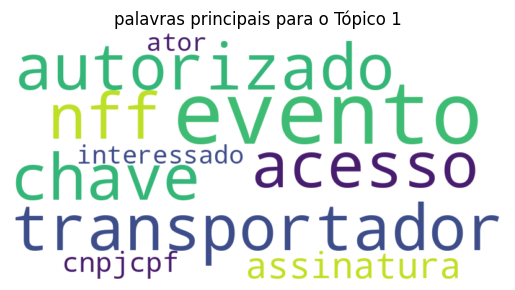

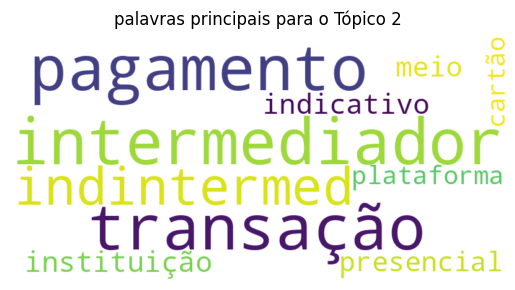

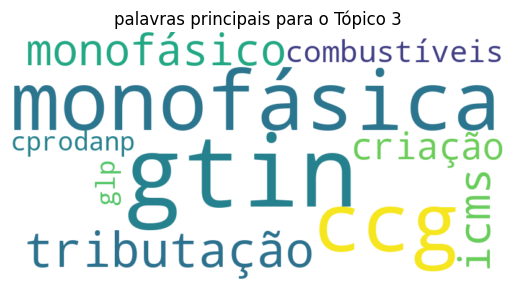

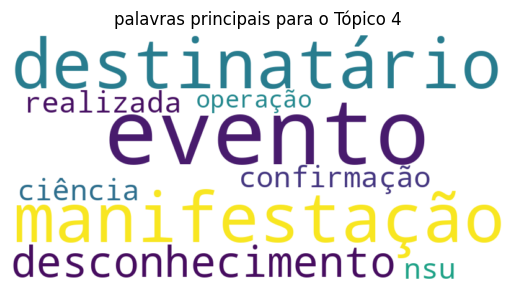

In [ ]:
for i, topic in enumerate(topics, start=1):
    topic_text = ' '.join(topic)
    wordcloud = WordCloud(width=800, height=400, background_color='white').generate(topic_text)

    plt.imshow(wordcloud, interpolation='bilinear')
    plt.title(f"palavras principais para o Tópico {i}")
    plt.axis("off")
    plt.show()

### Modelo utilizando apenas 1 documento

In [ ]:
registro_select = tokens_df.filter(df["id_doc"] == 41)
registro_select.show(5, vertical=True)


-RECORD 0-------------------------------
 Nome do arquivo | Manual_de_Orienta... 
 tokens          | [[sistema,, nota,... 
 id_doc          | 41                   



In [ ]:
cv_1 = CountVectorizer(inputCol="tokens", outputCol="raw_features")
cv_model_1 = cv.fit(registro_select)

vectorized_tokens_onedoc = cv_model_1.transform(registro_select)
vectorized_tokens_onedoc.show(vertical=True)

-RECORD 0-------------------------------
 Nome do arquivo | Manual_de_Orienta... 
 tokens          | [[sistema,, nota,... 
 id_doc          | 41                   
 raw_features    | (642,[0,1,2,3,4,5... 



In [ ]:
idf_1 = IDF(inputCol="raw_features", outputCol="features")
idf_model_1 = idf_1.fit(vectorized_tokens_onedoc)
vectorized_row = idf_model_1.transform(vectorized_tokens_onedoc)
vectorized_row = vectorized_row.drop(fun.col('raw_features'))
vectorized_row.show(truncate=False)

+--------------------------------------------+------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------

In [ ]:
lda_onedoc = LDA(k=2)
model_onedoc = lda_onedoc.fit(vectorized_row)
perplexity = model_onedoc.logPerplexity(vectorized_row)
print(perplexity)

inf


In [ ]:
#infinito o resultado do grau de perplexidade, não conseguindo ser mensurado

In [ ]:
lda_onedoc = LDA(k=2)
model_onedoc = lda_onedoc.fit(vectorized_row)

In [ ]:
vocab = cv_model_1.vocabulary
raw_topics = model_onedoc.describeTopics().collect()
topics_inds = [ind.termIndices for ind in raw_topics]

In [ ]:
topics = []
for topic in topics_inds:
  _topic = []
  for ind in topic:
    _topic.append(vocab[ind])
  topics.append(_topic)

In [ ]:
for i, topic in enumerate(topics, start=1):
  print(f"topico {i}: {topic}")

topico 1: ['lote,', 'obrigatórios,', 'autorização,', 'devolverá,', 'registro,', 'enat,', 'acrônimo,', 'vinculado,', 'assíncronos,', 'particular,']
topico 2: ['exceção,', 'existirá,', 'respectiva,', 'pois,', 'sistemas,', 'consultar,', 'dezembro,', 'finanças,', 'protocolo,', 'conceitual,']
